## ewf-ext-02-03-03 - NDVI long term averages of growing season time series per pixel

NDVI long term averages of growing season time series per pixel

---

### <a name="service">Service definition

In [22]:
service = dict([('title', 'NDVI long term averages of growing season time series per pixel'),
                ('abstract', 'NDVI long term averages of growing season time series per pixel'),
                ('id', 'ewf-ext-02-03-03')])

### <a name="parameter">Parameter Definition 

In [69]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'P001'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the NDVI stats' identifiers

In [23]:
# 2015, 2015
#difNdvi
input_identifiers = ('LE07_difNdvi_P001_2015005_2015020.tif', 'LE07_difNdvi_P001_2015005_2015020.tif')

**Input references**

This is the MODIS stack catalogue references

In [24]:
input_references = tuple(['https://catalog.terradue.com/modis/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [25]:
data_path = "/workspace/dev/ewf-ext-02-03-02/src/main/app-resources/notebook/libexec"

**Aux folders**

In [26]:
output_folder = ''

In [27]:
temp_folder = 'temp'

#### Import Modules

In [35]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import datetime

import pdb

#### Auxiliary vars

In [29]:
check_results = True

#### Auxiliary methods

In [68]:
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            
    
def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type

#def matrix_sum(mat1, mat2, no_data_value=None):
#    if no_data_value is not None:
#        if not isinstance(mat1, int):
#            mat1[(mat1 == no_data_value)] = 0
#        if not isinstance(mat2, int):
#            mat2[(mat2 == no_data_value)] = 0
#    return mat1 + mat2




def matrix_sum(mat1, mat2, no_data_value=None):
    if no_data_value is not None:
        if not isinstance(mat1, int):
            mat1[(mat1 == no_data_value)] = 0
        if not isinstance(mat2, int):
            mat2[(mat2 == no_data_value)] = 0
            
            
    msum = mat1 + mat2
        
    msum[(mat1 == 0)] = 0
    msum[(mat2 == 0)] = 0
        
    return msum


def write_output_image(filepath, output_matrix, image_format, data_format, output_projection=None, output_geotransform=None, mask=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    if mask is not None:
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
        
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    
    output.FlushCache()
    
def calc_average(matrix_list, n_years):
    if not isinstance(matrix_list, list):
        return 0
    result = matrix_list[0]
    for i in range(1, n_years):
        result = matrix_sum(result, matrix_list[i])
    
    return np.divide(result, (n_years*1.00))

def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list



def calc_lta(file_list):
    
    
    #file_list = []
    #if not os.path.isdir('tmp_data'):
    #    os.mkdir('tmp_data')
    #for enclosure in dataframe['enclosure'].tolist():
    #    filepath = 'tmp_data/' + os.path.basename(enclosure)
    #    status = get_product(enclosure, filepath)
    #    if status == 200:
    #        file_list.append(filepath)
    #print(file_list)
    
    
    
    if file_list:
        
        n_years = len(file_list)
        agr_period_matrix = get_matrix_list(file_list)
        print('Aggregations converted to matrices')
        lta = calc_average(agr_period_matrix, n_years)
        projection, geotransform, no_data_value, data_type = get_metadata(file_list[0])
        
        #for file_ in file_list:
        #    os.remove(file_)
        
        return lta, projection, geotransform, no_data_value, data_type
    
    else:
        return None, None, None
    
    
    

def write_output(temp_folder, lta, period_start_date, period_end_date, product_type, region, projection, geo_transform, image_format, no_data_value, data_type):
    
    start_day_year = "{:03d}".format(period_start_date.timetuple().tm_yday)
    end_day_year = "{:03d}".format(period_end_date.timetuple().tm_yday)
       
    #path_name_ini = os.path.join(temp_folder, 'LTA_' )
    #output_name = temp_folder + '/' + 'LTA_' + product_type + '_' + region + '_' + str(period_N) + '_' + agr_type + '_' + start_day_month + '_' + end_day_month + '_' + str(period_start_date.year) + '_' + str(period_end_date.year) + '.tif'
    
    #output_name = os.path.join(temp_folder, 'LTA_' + product_type + '_' + region +  '_' + start_day_month + '_' + end_day_month + '_' + str(period_start_date.year) + '_' + str(period_end_date.year) + '.tif')
    
    output_name = os.path.join(temp_folder, '_'.join(['LTA', product_type, region, start_day_year + '-' + end_day_year, str(period_start_date.year) + '-' + str(period_end_date.year)]) + '.tif' )
    
    write_output_image(output_name, lta, image_format, data_type, projection, geo_transform, no_data_value=no_data_value)
    
    return output_name



def get_formatted_date(date_str):
    date = datetime.datetime.strftime(date_str, '%Y-%m-%dT00:00:00Z')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    first_date = get_formatted_date(first_date)
    last_date = get_formatted_date(last_date)
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))

#### Auxiliary folders

In [31]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

Compute Long Term Averages

In [32]:
#N = nv

file_list = [os.path.join(data_path, in_id.split('/')[-1]) for in_id in input_identifiers]

#file_list

lta, projection, geotransform, no_data_value, data_type = calc_lta(file_list)




Aggregations converted to matrices


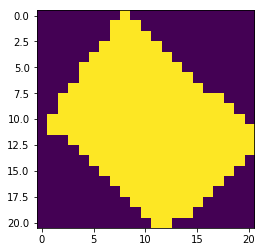

In [33]:
# CHECK
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(lta)
    plt.show()

In [62]:
print(file_list)

#print(startdate_firstproduct.timetuple().tm_yday)

['/workspace/dev/ewf-ext-02-03-02/src/main/app-resources/notebook/libexec/LE07_difNdvi_P001_2015005_2015020.tif', '/workspace/dev/ewf-ext-02-03-02/src/main/app-resources/notebook/libexec/LE07_difNdvi_P001_2015005_2015020.tif']
020
005
5


#### write output

In [70]:

filename = os.path.splitext(os.path.basename(file_list[0]))[0].split('_')

# first image
startdate = os.path.splitext(os.path.basename(file_list[0]))[0].split('_')[-2]
enddate = os.path.splitext(os.path.basename(file_list[0]))[0].split('_')[-1]

startdate_firstproduct = datetime.datetime.strptime(startdate, "%Y%j")
enddate_firstproduct = datetime.datetime.strptime(enddate, "%Y%j")


# last image
startdate = os.path.splitext(os.path.basename(file_list[-1]))[0].split('_')[-2]
enddate = os.path.splitext(os.path.basename(file_list[-1]))[0].split('_')[-1]

stardate_lastproduct = datetime.datetime.strptime(startdate, "%Y%j")
enddate_lastproduct = datetime.datetime.strptime(enddate, "%Y%j")



##startdate = dt.datetime.strptime(startdate, '%Y')
##enddate = dt.datetime.strptime(enddate, '%Y')

#LE07_difNdvi_P001_2015005_2015020.tif
region = filename[2]
prod_type = filename[1]




if lta is not None:
    #pdb.set_trace()
    filename = write_output(output_folder, lta, stardate_firstproduct, enddate_lastproduct, prod_type, region, projection, geotransform, 'GTiff', no_data_value, data_type)
    
    write_properties_file(filename, stardate_firstproduct, enddate_lastproduct, regionOfInterest['value'])

    
#lta[310,210]



In [ ]:
# CHECK

# CHECK
#if check_results:
#    
#    import rasterio
#
#    from rasterio.plot import show



#    # Load data
#    raster = filename

#    data = rasterio.open(raster)

#    show(data)

    #data = georasters.from_file(raster)

    # Plot data
    # data.plot()

#### Remove temporay files and folders

In [ ]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)